## Graphs of CPU load tests
This notebook creates the graphs of perf data collected with tool test_Spark_CPU_memory_sparkmeasure.py  
Performance data is for testing servers of the types: HDP6 and RAC55.  

We don't report the exact CPU model in this doc.
We omit the configuration of networking and I/O, as not relevant for these tests.  
The servers were all installed with the same OS version: RHEL 7.9.  
Systems:  
---

HDP6:

    32 physical cores (2 sockets, 16 physical cores each),  
      64 logical cores visible on the OS due to hyperthreading
    CPU max freq: 3.0 GHz
    CPU from 2017
    L1 caches: 32K + 32K, L2 cache 512K, L3 cache 16384K
    RAM: DDR4, 512 GB

RAC55:

    16 physical cores (2 sockets, 8 physical cores each), 
      32 logical cores visible on the OS due to hyperthreading
    CPU max freq: 4.2 GHz
    CPU from 2019
    L1 caches: 32K + 32K, L2 cache 512K, L3 cache 32768K
    RAM: DDR4, 1 TB
 

In [3]:
# This notebook uses pandas to read and process Data in csv format
import pandas as pd

In [4]:
# Path to the data
# Data comes from the output of the tool test_Spark_CPU_memory_sparkmeasure.py  
# See https://github.com/LucaCanali/Miscellaneous/tree/master/Perf_Testing
PATH = "../Data/"

In [5]:
data = []
data.append({'key': 'HDP6', 'val': pd.read_csv(PATH + "test_Spark_CPU_memory_sparkmeasure_HDP6_1_70.csv", sep = ',')})
data.append({'key': 'RAC55', 'val': pd.read_csv(PATH + "test_Spark_CPU_memory_sparkmeasure_RAC55_1_40.csv", sep = ',')})

In [6]:
data[0].get('val').head()

,Num_concurrent_tasks,run_number,job_run_time (sec),executorRunTime (sec),executorCpuTime (sec),jvmGCTime (sec)
0,1,1,665.86,659.44,648.29,9.28
1,1,2,637.72,633.85,629.21,5.15
2,1,3,646.37,642.56,637.69,5.25
3,2,1,336.52,668.76,665.49,3.85
4,2,2,334.52,665.14,662.07,3.57


In [7]:
data[0].get('val').columns

Index(['Num_concurrent_tasks', 'run_number', 'job_run_time (sec)',
       'executorRunTime (sec)', 'executorCpuTime (sec)', 'jvmGCTime (sec)'],
      dtype='object')

In [8]:
# Common code for Graphs setup and configuration

import matplotlib.pyplot as plt
plt.clf()
plt.style.use('default')

width = 12
height = 5

node_config = {1: {'name': 'HDP6', 'linestyle': 'solid', 'color': 'black', 'alpha': 1.0, 'linewidth': 3}, 
               2: {'name': 'RAC55', 'linestyle': 'solid', 'color': 'red', 'alpha': 1.0, 'linewidth': 3}
              }


<Figure size 640x480 with 0 Axes>

### Plot job duration as a function of number of concurrent workers
This is the raw data from the load generator 

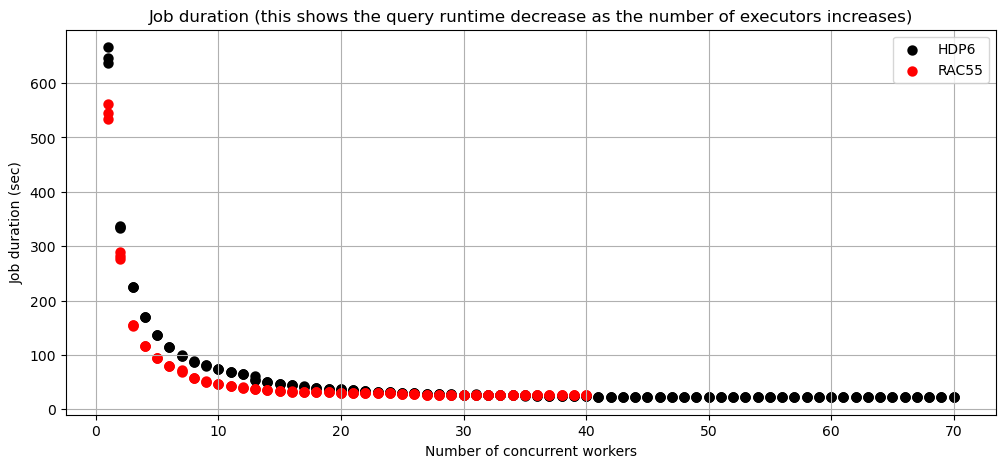

In [11]:
# Job duration
fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    df.plot(kind='scatter', x='Num_concurrent_tasks', y='job_run_time (sec)', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title("Job duration (this shows the query runtime decrease as the number of executors increases)")
#ax.set_ylim([20, 40])
ax.set_xlabel('Number of concurrent workers')
ax.set_ylabel('Job duration (sec)')

ax.grid()
plt.show()

In [7]:
# compute job per minute per worker


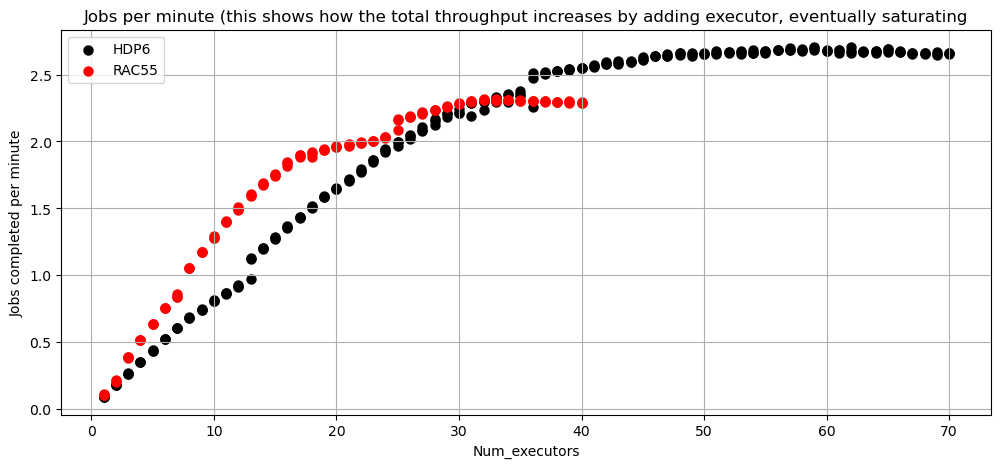

In [12]:
# Job duration
fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    df['jobs_permin'] = 60 / df['job_run_time (sec)']
    df.plot(kind='scatter', x='Num_concurrent_tasks', y='jobs_permin', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title("Jobs per minute (this shows how the total throughput increases by adding executor, eventually saturating")
#ax.set_ylim([1.0, 3])
ax.set_xlabel('Num_executors')
ax.set_ylabel('Jobs completed per minute')

#plt.text(16.0, 2.7, '  RAC55=16 cores', color='red')
#ax.axvline(16.0, linestyle='--', color='red')

#plt.text(32.0, 2.3, '  HDP6=32 cores', color='black')
#ax.axvline(32.0, linestyle='--', color='black')

ax.grid()

plt.show()

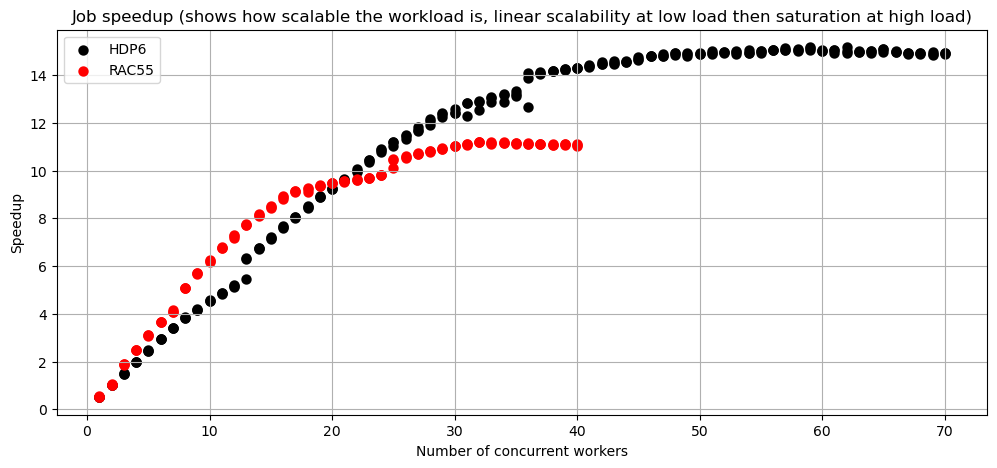

In [13]:
# Speedup
fig, ax = plt.subplots(figsize=(width, height))

for i, measurement in enumerate(data):
    df = measurement.get('val')
    instance = i + 1
    base = df['job_run_time (sec)'].iloc[3] # take the data point for n_exec=1, run=3
    df['speedup'] = base / df['job_run_time (sec)']
    df.plot(kind='scatter', x='Num_concurrent_tasks', y='speedup', ax=ax, 
               linestyle=node_config[instance]['linestyle'],
               color=node_config[instance]['color'],
               alpha=node_config[instance]['alpha'],
               linewidth=node_config[instance]['linewidth'],
               label=node_config[instance]['name'])

ax.set_title('Job speedup (shows how scalable the workload is, linear scalability at low load then saturation at high load)')
#ax.set_ylim([0, 50])
ax.set_xlabel('Number of concurrent workers')
ax.set_ylabel('Speedup')

ax.grid()

plt.show()